# E13
---

## Environment Setting
---

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn as sns
sns.set_context('paper')

env: SM_FRAMEWORK=tf.keras


In [15]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [16]:
workspace_path = '/home/aiffel-dj22/workspace/Hackerton/segmentation_models/Model'

In [17]:
FILE_PATH = os.path.join(workspace_path, 'E3/util/LV2_PNG_DATASET.h5')
                         
BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/val"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

BUIDING_COLOR_MAP = COLOR_MAP[0]
ROAD_COLOR_MAP = COLOR_MAP[1]

In [18]:
COLOR_MAP[0:2]

[(165, 42, 42), (0, 192, 0)]

### dataset 확인

(1024, 1024) 2


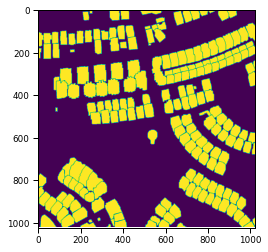

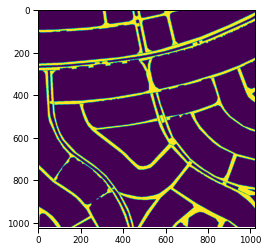

52.03409194946289


In [40]:
with h5py.File(FILE_PATH, "r") as f:
    i = 50
    
    masks = [(f[TRAIN_LABEL_PATH][i] == v) for v in COLOR_MAP[0:2]]
    masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
                      for mask in masks]
    
    print(masks[0].shape, len(masks))
    
    mask = np.stack(masks, axis=-1).astype('float')    
    
    plt.imshow(mask[:, :, 0])
    plt.show()
    plt.imshow(mask[:, :, 1])
    plt.show()
    total = 1024*1024
    building_area = masks[0].sum()
    road_area = masks[1].sum()
    print((building_area+road_area)/ total*100)

(1024, 1024) 2


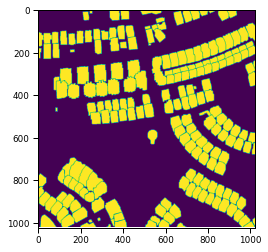

In [57]:
with h5py.File(FILE_PATH, "r") as f:
    i = 50
    
    masks = [(f[TRAIN_LABEL_PATH][i] == v) for v in COLOR_MAP[0:2]]
    masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
                      for mask in masks]
    
#   mask = masks[0] + masks[1] 
    mask = np.stack(masks, axis=-1).astype('float')  
    
    print(masks[0].shape, len(masks))
    
    plt.imshow(mask[:,:,0])
    plt.show()

28.41644287109375


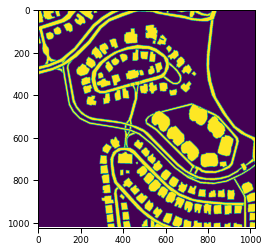

77.06480026245117


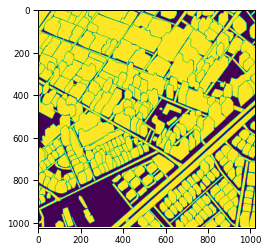

47.93100357055664


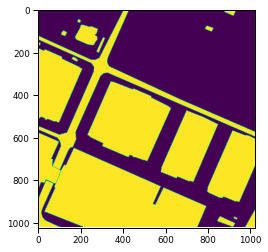

35.59989929199219


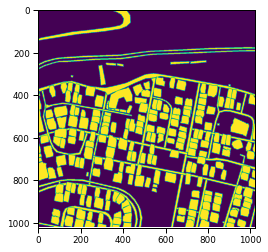

20.88327407836914


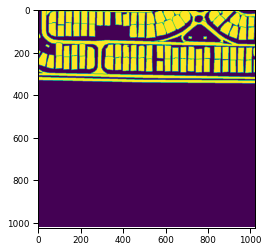

5.497932434082031


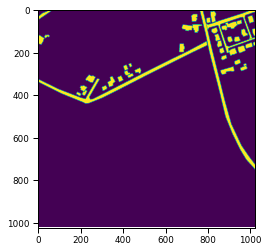

63.00344467163086


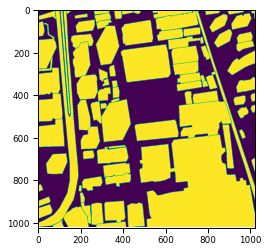

45.180320739746094


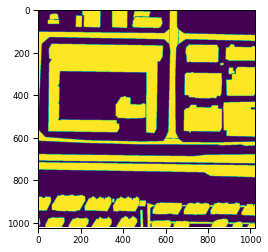

37.27836608886719


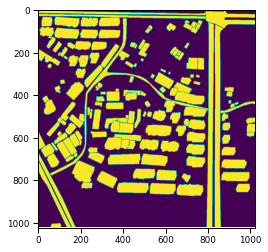

33.56208801269531


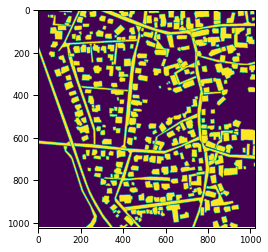

1.7255783081054688


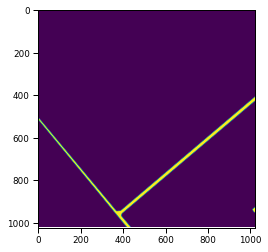

45.62788009643555


KeyboardInterrupt: 

In [21]:
with h5py.File(FILE_PATH, "r") as f:
    total = 1024*1024
    
    limit = 5 # 1% 이하 제거
    
    for i in range(len(f[TRAIN_LABEL_PATH])):
        masks = [(f[TRAIN_LABEL_PATH][i] == v) for v in COLOR_MAP]
        masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
                      for mask in masks]
        
        mask = masks[0] + masks[1]
        area = mask.sum()
        print((area / total)*100)
        plt.imshow(mask)
        plt.show()
        

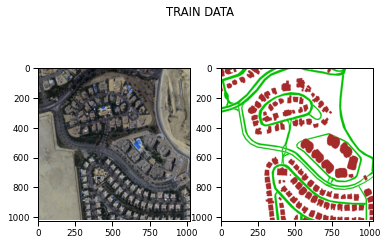

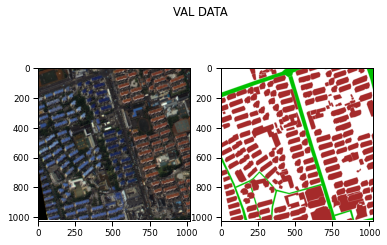

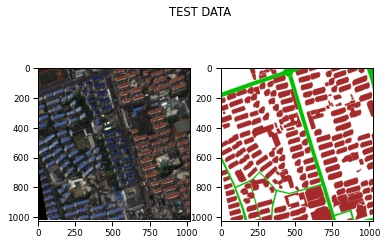

In [22]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i][:, :, :3])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i][:, :, :3])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_IMG_PATH][i][:, :, :3])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_LABEL_PATH][i])
    plt.show()

## Split and Save image
---

### 함수정의

In [23]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / 5.0))
        pos_j = int(slice_pos % 5)
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [24]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

In [25]:
def random_crop(img, mask, crop_num, height=256, width=256): 
    cropper = A.RandomCrop(height, width)
    croped = [cropper(image=img, mask=mask) for _ in range(crop_num)]
    return [sub['image'] for sub in croped], [sub['mask'] for sub in croped]

In [26]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [27]:
def filtering_contain_zero_label(imgs, labels, threshold=1, img_size=256, saver=1):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    하지만, threshold 미만은 모든 데이터를 지우는 것은 데이터 학습의 효율을 떨어뜨릴 수 있으므로,
    이 과정에 확률을 넣어 (면적 차지 비율)% 확률로 threshold 미만의 데이터가 필터링 되지 않도록 한다.
		예외. 비율이 0인 데이터는 0.001% 확률로 필터링 되지 않는다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[1-(x/100), x/100])[0]
    rand_zero = lambda : np.random.choice([0, 1], 1, p=[0.999, 0.001])[0]

    label_areas = np.array([label.sum() for label in labels])
    rates = label_areas / (img_size * img_size) * 100
    filter_mask = filter_mask = [True if rate > threshold else 
                rand_zero() if rate == 0 else rand(rate) for rate in rates]
    
    filtered_imgs = [img for img, mask in zip(imgs, filter_mask) if mask]
    filtered_labels = [label for label, mask in zip(labels, filter_mask) if mask]
    return filtered_imgs, filtered_labels

In [28]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

In [31]:
def split_and_save(FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, SPLIT_DIR, img_size=256, split_cnt=25):
    with h5py.File(FILE_PATH, "a") as f:
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[SPLIT_DIR]
        f[BASE_DIR].create_group('split')
        f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size, 3), np.uint8)
        f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size, 2), np.float32)
        sub_idx = 0
        
        
        for i in tqdm(range(f[IMG_PATH].shape[0])):
            
            img = f[IMG_PATH][i]
            masks = [(f[TRAIN_LABEL_PATH][i] == v) for v in COLOR_MAP[0:2]]
            masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
                      for mask in masks]
        
      #      mask = masks[0] + masks[1] 
            mask = np.stack(masks, axis=-1).astype('float')    

            sub_imgs, sub_labels = random_crop(img, mask, split_cnt)
            sub_idx = save_png_imgs_labels(f[SPLIT_DIR], sub_idx, sub_imgs, sub_labels)
            
            filtered_imgs, filtered_labels = filtering_contain_zero_label(sub_imgs, sub_labels)

In [32]:
split_and_save(FILE_PATH, BASE_TARIN_DIR, TRAIN_IMG_PATH, TRAIN_LABEL_PATH, TRAIN_SPLIT_DIR, img_size=256, split_cnt=25)
split_and_save(FILE_PATH, BASE_VAL_DIR, VAL_IMG_PATH, VAL_LABEL_PATH, VAL_SPLIT_DIR, img_size=256, split_cnt=25)
split_and_save(FILE_PATH, BASE_TEST_DIR, TEST_IMG_PATH, TEST_LABEL_PATH, TEST_SPLIT_DIR, img_size=256, split_cnt=25)

100%|██████████| 30/30 [00:01<00:00, 16.70it/s]


### Sample

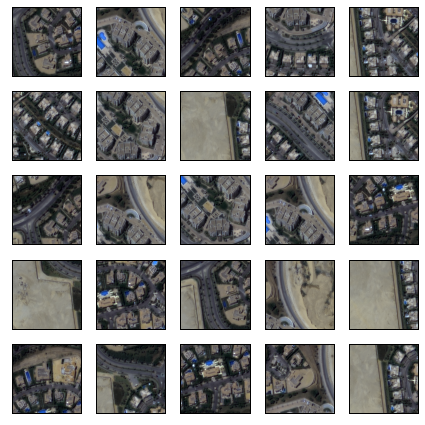

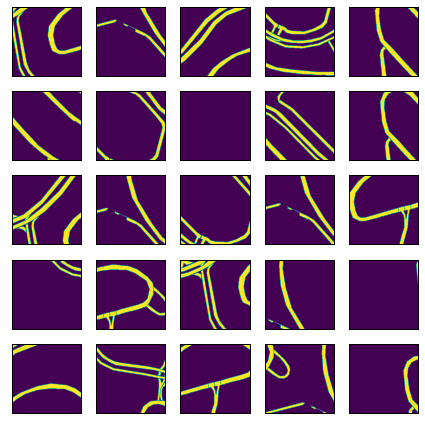

In [58]:
with h5py.File(FILE_PATH, "a") as f:
    idx = 0
    imgs = f[TRAIN_SPLIT_IMG_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(imgs):
        if i == 25: break
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()
    
    masks = f[TRAIN_SPLIT_LABEL_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(masks):
        if i == 25: break
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img[:,:,1])
            
    plt.tight_layout()
    plt.show()

In [34]:
def show_area_distributaion(FILE_PATH, DIR_PATH):
    with h5py.File(FILE_PATH, "r") as f:
        img_size = f[DIR_PATH].shape[0]
        building_areas = np.sum(f[DIR_PATH], axis=1)
        building_areas = np.sum(building_areas, axis=1)

    plt.figure(figsize=(12,5))
    sns.histplot(building_areas, bins=100)
    plt.show()

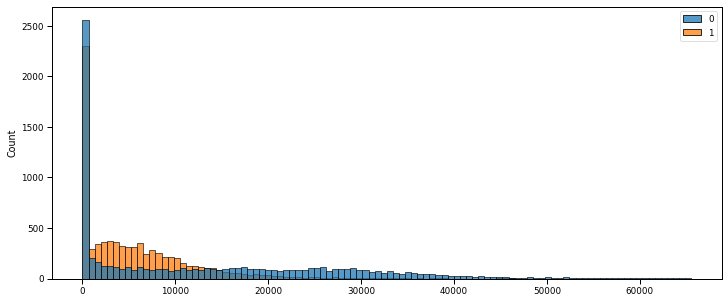

In [35]:
show_area_distributaion(FILE_PATH, TRAIN_SPLIT_LABEL_PATH)

## Dataloader and utility functions
---

In [59]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [60]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [61]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [62]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
          
    
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

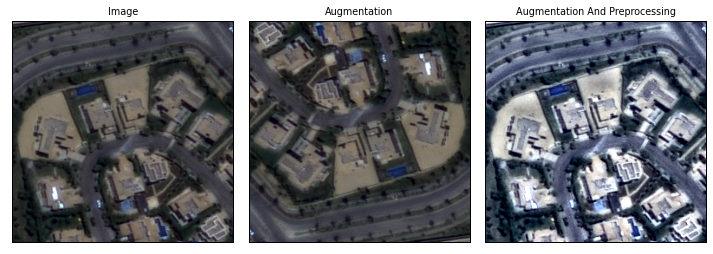

TypeError: Invalid shape (256, 256, 2) for image data

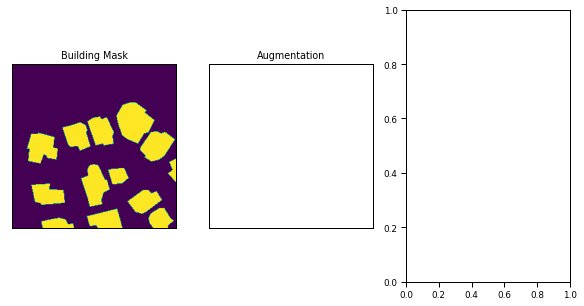

In [64]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 0
image, mask = dataset[idx] # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0], 
    augmentation=image_aug[0],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0])
)

visualize(
    building_mask=mask[0][:,:,0],
    augmentation=mask_aug[0],
    augmentation_and_preprocessing=mask_aug_pre[0]
)

# Train Model

### functions

In [65]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_SPLIT_IMG_PATH,
        TRAIN_SPLIT_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_SPLIT_IMG_PATH, 
        VAL_SPLIT_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [66]:
import time
import datetime
def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        return result
    return wrapper_fn

In [67]:
def get_cosine_lr(initial_learning_rate, t_period, lr_min=0.):
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)

In [84]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building','road']

    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2021)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/E13/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          verbose=1, 
                                          mode='min'),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [85]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
# show_history_plot(new_history)

In [ ]:
def merge_img(sub_imgs, pts):
    merged = np.zeros((1024, 1024, 3))
    for i, (x0, x1, y0, y1) in enumerate(pts):
        sub_a = merged[x0:x1, y0:y1, :]
        sub_b = sub_imgs[i]
        added = np.where(sub_a > sub_b, sub_a, sub_b)
        ch1_2_and = np.logical_and(added[:,:,0], added[:,:,1])
        ch1_3_and = np.logical_and(added[:,:,0], added[:,:,2])
        ch2_3_and = np.logical_and(added[:,:,1], added[:,:,2])
        added[:,:,1] -= ch1_2_and
        added[:,:,2] -= ch1_3_and
        added[:,:,2] -= ch2_3_and
        merged[x0:x1, y0:y1, :] = added
    return merged

In [86]:
def inference(model, img, crop_pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])
    sub_imgs = split_png(img, crop_pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    predict_imgs = [model.predict(img) for img in sub_imgs]
    predict_imgs = [predict.squeeze() for predict in predict_imgs]
    predict_imgs = [predict.round().clip(0, 1) for predict in predict_imgs]
    merged_img = merge_img(predict_imgs, crop_pts)
    return merged_img

In [87]:
def show_inference(model):
    pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(5):
            img = f[TEST_IMG_PATH][idx]
            masks = [(f[TRAIN_LABEL_PATH][i] == v) for v in COLOR_MAP[0:2]]
            masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
                      for mask in masks]
            mask = np.stack()
#            mask = masks[0] + masks[1] 
            
            predicted = inference(model, img, pts)
            images = {'Image': img, 
                      'Ground Truth': mask,
                      'Prediction': predicted}

            visualize(
                image=img,
                ground_truth=mask,
                predicted=predicted
            )

### E10-1
- optimizer = Adam, 1e-3
- EPOCHS=25
- Batch=8

In [88]:
lr = 1e-4
BATCH_SIZE = 8
EPOCHS=10
optim = keras.optimizers.Adam(lr=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [89]:
!pwd

/home/aiffel-dj22/workspace/Hackerton/segmentation_models/Model


In [90]:
model_13_1, callbacks = get_model('E13-1',
                                 optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  './trained_model/E13/E13_1_best_model.h5',
                                  patience=5)

In [ ]:
start_time = time.time()

history_13_1 = model_13_1.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/10
1013/1013 [==============================] - 285s 266ms/step - loss: 0.7063 - iou_score: 0.2172 - f1-score: 0.3199 - val_loss: 0.9404 - val_iou_score: 0.0975 - val_f1-score: 0.1678
Epoch 2/10
1013/1013 [==============================] - 233s 230ms/step - loss: 0.6344 - iou_score: 0.2811 - f1-score: 0.3834 - val_loss: 0.9534 - val_iou_score: 0.0933 - val_f1-score: 0.1606
Epoch 3/10
1013/1013 [==============================] - 250s 246ms/step - loss: 0.5820 - iou_score: 0.3304 - f1-score: 0.4345 - val_loss: 1.0047 - val_iou_score: 0.0909 - val_f1-score: 0.1568
Epoch 4/10
 184/1013 [====>.........................] - ETA: 3:22 - loss: 0.5751 - iou_score: 0.3352 - f1-score: 0.4388

In [ ]:
show_history_plot(history_13_1.history)

#### evaluation

In [ ]:
model_13_1.load_weights('./trained_model/E13/E13_1_best_model.h5')

In [ ]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_13_1.evaluate(valid_datagenerator)
test_metrix = model_13_1.evaluate(test_datagenerator)

In [ ]:
BACKBONE = 'efficientnetb3'
show_inference(model_13_1)

## additional information
---

### 1. learning rate
- ref : https://github.com/peteryuX/pcdarts-tf2/blob/4ecf2224cd414586d988c2d3d4316af0d518e8e8/modules/lr_scheduler.py
- ref : https://velog.io/@changdaeoh/learningrateschedule

In [ ]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
mpl.style.use('default')
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)


def CosineAnnealingLR(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)


def show_learning_rate(lr_scheduler, title="Title"):
    N_iter = 10000
    step_list = list(range(0, N_iter, 10))
    lr_list = []
    for i in step_list:
        current_lr = lr_scheduler(i).numpy()
        lr_list.append(current_lr)

    plt.figure(1)
    plt.subplot(111)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(title, fontsize=16, color='k')
    plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
    legend = plt.legend(loc='upper right', shadow=False)
    ax = plt.gca()
    labels = ax.get_xticks().tolist()
    for k, v in enumerate(labels):
        labels[k] = str(int(v / 1000)) + 'K'
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Iteration')
    fig = plt.gcf()
    plt.show()

In [ ]:
show_learning_rate(MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5), 'MultiStepLR')
show_learning_rate(CosineAnnealingLR_Restart(2e-4, 2500, 1e-7), 'CosineAnnealingLR_Restart')
show_learning_rate(CosineAnnealingLR(0.025, 10000, 0), 'CosineAnnealingLR')